# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=2,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          tokenizer_version=1,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.01)


In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
WANDB_NAME = f"{config.model}-{config.max_length}"

In [7]:
wandb.login(key=os.environ.get('WANDB_NOTEBOOK_NAME'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [9]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(train_loader, device)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Validation: 100%|██████████| 155/155 [00:25<00:00,  6.01valid_batch/s]


Epoch 1 - avg_train_loss: 1.1677  avg_val_loss: 0.9334  time: 221s
Epoch 1 - Score: 0.7007
Epoch 1 - Save Best Score: 0.7007 Model


Validation: 100%|██████████| 155/155 [00:23<00:00,  6.62valid_batch/s]


Epoch 2 - avg_train_loss: 0.9447  avg_val_loss: 0.9138  time: 211s
Epoch 2 - Score: 0.7257
Epoch 2 - Save Best Score: 0.7257 Model
========== Fold: 0 result ==========
Score: 0.7257
========== Fold: 1 training ==========


Validation: 100%|██████████| 126/126 [00:19<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1843  avg_val_loss: 1.0207  time: 205s
Epoch 1 - Score: 0.7859
Epoch 1 - Save Best Score: 0.7859 Model


Validation: 100%|██████████| 126/126 [00:19<00:00,  6.61valid_batch/s]


Epoch 2 - avg_train_loss: 0.9625  avg_val_loss: 1.0051  time: 205s
Epoch 2 - Score: 0.7509
========== Fold: 1 result ==========
Score: 0.7859
========== Fold: 2 training ==========


Validation: 100%|██████████| 109/109 [00:16<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.1506  avg_val_loss: 1.1327  time: 207s
Epoch 1 - Score: 0.6261
Epoch 1 - Save Best Score: 0.6261 Model


Validation: 100%|██████████| 109/109 [00:16<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9254  avg_val_loss: 1.1326  time: 207s
Epoch 2 - Score: 0.6248
========== Fold: 2 result ==========
Score: 0.6261
========== Fold: 3 training ==========


Validation: 100%|██████████| 82/82 [00:12<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1507  avg_val_loss: 1.1434  time: 211s
Epoch 1 - Score: 0.7119
Epoch 1 - Save Best Score: 0.7119 Model


Validation: 100%|██████████| 82/82 [00:13<00:00,  6.08valid_batch/s]


Epoch 2 - avg_train_loss: 0.9658  avg_val_loss: 1.5792  time: 224s
Epoch 2 - Score: 0.5844
========== Fold: 3 result ==========
Score: 0.7119
========== Fold: 4 training ==========


Validation: 100%|██████████| 122/122 [00:20<00:00,  6.04valid_batch/s]


Epoch 1 - avg_train_loss: 1.1829  avg_val_loss: 1.0380  time: 226s
Epoch 1 - Score: 0.7647
Epoch 1 - Save Best Score: 0.7647 Model


Validation: 100%|██████████| 122/122 [00:20<00:00,  6.02valid_batch/s]


Epoch 2 - avg_train_loss: 0.9481  avg_val_loss: 0.9761  time: 225s
Epoch 2 - Score: 0.7613
========== Fold: 4 result ==========
Score: 0.7647
========== Fold: 5 training ==========


Validation: 100%|██████████| 58/58 [00:09<00:00,  6.08valid_batch/s]


Epoch 1 - avg_train_loss: 1.1543  avg_val_loss: 1.0118  time: 236s
Epoch 1 - Score: 0.5705
Epoch 1 - Save Best Score: 0.5705 Model


Validation: 100%|██████████| 58/58 [00:09<00:00,  6.09valid_batch/s]


Epoch 2 - avg_train_loss: 0.9440  avg_val_loss: 1.0959  time: 237s
Epoch 2 - Score: 0.5479
========== Fold: 5 result ==========
Score: 0.5705
========== Fold: 6 training ==========


Validation: 100%|██████████| 96/96 [00:15<00:00,  6.03valid_batch/s]


Epoch 1 - avg_train_loss: 1.1404  avg_val_loss: 1.2340  time: 228s
Epoch 1 - Score: 0.6609
Epoch 1 - Save Best Score: 0.6609 Model


Validation: 100%|██████████| 96/96 [00:14<00:00,  6.54valid_batch/s]


Epoch 2 - avg_train_loss: 0.9288  avg_val_loss: 1.0914  time: 219s
Epoch 2 - Score: 0.7440
Epoch 2 - Save Best Score: 0.7440 Model
========== Fold: 6 result ==========
Score: 0.7440
========== CV ==========
Score: 0.7438


In [13]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

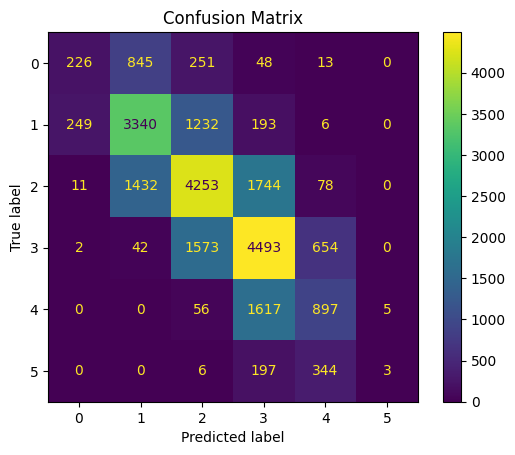

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [16]:
wandb.finish()

CV/qwk_score,▁
Fold 0/Accuracy,█▆▂▁▅█
Fold 0/Error Rate,▁▃▇█▄▁
Fold 0/F1 Score,▃█▇█▄▁
Fold 0/Precision,▃█▆▇▆▁
Fold 0/Recall,▂███▃▁
Fold 0/Sensitivity,▂███▃▁
Fold 0/Specificity,█▇▂▁▇█
Fold 1/Accuracy,▇▄▁▁▅█
Fold 1/Error Rate,▂▅██▄▁
Fold 1/F1 Score,▃██▇▁
